In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import mealpy
import time

2022-10-05 22:12:33.584404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
label = "Class"
class_weight = {0: 0.1, 1: 0.9}
metrics = ["Accuracy", "FalsePositives", "FalseNegatives", "Precision", "Recall"]

test_inds = np.random.rand(len(df)) < 0.2
train_df = df[~test_inds]
test_df = df[test_inds]

In [4]:
# convert pandas df to tensor ds
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
2022-10-05 22:13:00.311244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chase/opt/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [5]:
# create and fit default RF model
model = tfdf.keras.RandomForestModel(verbose=1)
model.compile(metrics=metrics)
model.fit(x=train_ds, class_weight=class_weight)

Use /var/folders/82/xcxtg5353f918mx036g0f8q00000gn/T/tmpeh5uz299 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:32.187901. Found 227868 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /var/folders/82/xcxtg5353f918mx036g0f8q00000gn/T/tmpeh5uz299/model/ with prefix 97c13800135d49ac


Model trained in 0:02:40.606924
Compiling model...


[INFO decision_forest.cc:639] Model loaded with 300 root(s), 64590 node(s), and 30 input feature(s).
[INFO abstract_model.cc:1249] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1637212029.5242293 mins


In [7]:
# test error
evaluation = model.evaluate(test_ds, return_dict=True)

for k, v in evaluation.items():
    print(f"{k}: {v:.3f}")

57/57 [==============================] - 11s 136ms/step - loss: 0.0000e+00 - Accuracy: 0.9996 - false_positives: 10.0000 - false_negatives: 15.0000 - precision: 0.8837 - recall: 0.8352
loss: 0.000
Accuracy: 1.000
false_positives: 10.000
false_negatives: 15.000
precision: 0.884
recall: 0.835


57/57 [==============================] - 5s 84ms/step


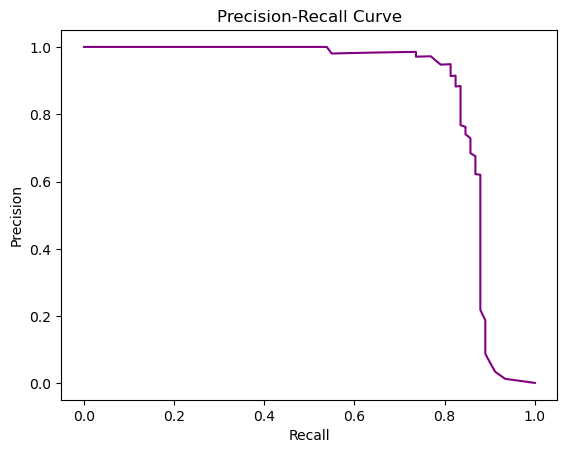

In [21]:
import matplotlib.pyplot as plt
from sklearn import metrics

#calculate precision and recall
precision, recall, thresholds = metrics.precision_recall_curve(test_df['Class'].to_numpy(), model.predict(test_ds))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()